# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [225]:
import numpy as np
import numpy.typing as tp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(k: tp.ArrayLike) -> float:
    k = np.array(k)
    total_amount = np.sum(k)
    probabilities = k[np.where(k != 0)] / total_amount
    entropy_values = -probabilities * np.log(
        probabilities)
    return round(np.sum(entropy_values), 2)

In [3]:
k1, k2 = 8, 2
entropy([k1, k2])  # Ответ

0.5

In [4]:
entropy([1, 1])  # не 1, так как логарифм натуральный

0.69

In [5]:
entropy([0, 2])

0.0

In [6]:
entropy([3, 1])

0.56

*Ответ:* 0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [7]:
def gini(r: tp.ArrayLike) -> float:
    r = np.array(r)
    total_amount = np.sum(r)
    probabilities = r[np.where(r != 0)] / total_amount
    gini_values = probabilities * (1 - probabilities)
    return np.sum(gini_values)

In [8]:
print(gini([13, 4]))
print(gini([1, 1]))
print(gini([1, 0]))

0.35986159169550175
0.5
0.0


In [9]:
from typing import Callable


def q(r_l: tp.ArrayLike, r_r: tp.ArrayLike, h: Callable = entropy, task: str = "classification") -> float:
    TASKS = ["classification", "regression"]

    r_l = np.array(r_l)
    r_r = np.array(r_r)
    r_m: tp.ArrayLike
    if task == "classification":
        r_m = r_l + r_r
    elif task == "regression":
        r_m = np.append(r_l, r_r)
    else:
        raise ValueError(f"task can be only: {TASKS}")
    return h(r_m) - h(r_l) * sum(r_l) / sum(r_m) - h(r_r) * sum(r_r) / sum(r_m)

In [10]:
round(q([k1, 0], [0, k2], gini), 2)  # Ответ

0.32

In [11]:
q([6, 0], [0, 6], gini)  # perfect

0.5

In [12]:
q([3, 3], [3, 3], gini)

0.0

In [13]:
q([3, 3], [0, 0], gini)

0.0

*Ответ:* 0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [14]:
# среднее
np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [15]:
from collections import Counter
from typing import List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [322]:
# Задание не слишком точно сформировано, так что на всякий случай дополнительно к этой функции реализовал ещё две
# find_best_split_gini - вместо критерия информативности использовал критерий джини
# find_best_split_multiclass - вместо бинарной классификации реализовал многоклассовую классификацию

def find_best_split(
        feature_vector: Union[np.ndarray, pd.DataFrame],
        target_vector: Union[np.ndarray, pd.Series],
        task: str = "classification",
        feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосeдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева. Без пустых подвыборолк
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds). В моём случае критерий информативности
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число). В моём случае критерий информативности
    """
    TASKS = ["classification", "regression"]
    FEATURE_TYPES = ["real", "categorical"]

    # выбор h для задачи (gini для классификации и var для регрессии).
    h: Callable
    if task == "classification":
        h = gini
    elif task == "regression":
        h = np.var
    else:
        raise ValueError(f"task can be only: {TASKS}")

    # Реализация для каждого типа
    if feature_type == "real":

        # подсчёт среднего значения между уникальными пороговыми значениями
        # нужен только feature_vector для получения пороговых значений

        unique_feature_vector = np.sort(np.unique(feature_vector))

        thresholds = np.unique(unique_feature_vector[:len(unique_feature_vector) - 1] + unique_feature_vector[1:len(
            unique_feature_vector)]) / 2  # среднее между всеми парами чисел

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Буду классифицировать только для двух, так как для нескольких используется one-vs-all или all-vs-all классификация.
            # Ну можно ещё сделать для нескольких признаков используя словарь, оставлю попытку реализовать подобной разбиение в конце тетради
            if len(np.unique(target_vector)) != 2:
                raise ValueError(
                    f"target should have binary classes, but got {len(np.unique(target_vector))} unique classes instead")
            unique_targets = np.sort(np.array(np.unique(target_vector)))
            class_0, class_1 = unique_targets

            for threshold in thresholds:
                left_targets = target_vector[np.argwhere(feature_vector < threshold).ravel()]
                right_targets = target_vector[np.argwhere(feature_vector >= threshold).ravel()]

                left_targets_counts = [np.sum(left_targets == class_0), np.sum(left_targets == class_1)]
                right_targets_counts = [np.sum(right_targets == class_0), np.sum(right_targets == class_1)]

                ginis = np.append(ginis,
                                  q(left_targets_counts, right_targets_counts, h))
        elif task == "regression":
            for threshold in thresholds:
                ginis = np.append(ginis, q(list(target_vector[np.argwhere(feature_vector < threshold)]),
                                           list(target_vector[np.argwhere(feature_vector >= threshold)]), h,
                                           "regression"))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best

    elif feature_type == "categorical":
        # Буду считать, что поле должно быть закодировано с помощью label кодирования.

        thresholds = np.array(np.unique(feature_vector))

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Буду классифицировать только для двух, так как для нескольких используется one-vs-all или all-vs-all классификация.
            # Ну можно ещё сделать для нескольких признаков используя словарь, оставлю попытку реализовать подобной разбиение в конце тетради
            if len(np.unique(target_vector)) != 2:
                raise ValueError(
                    f"target should have binary classes, but got {len(np.unique(target_vector))} unique classes instead")
            unique_targets = np.sort(np.array(np.unique(target_vector)))
            class_0 = unique_targets[0]
            class_1 = unique_targets[1]
            for threshold in thresholds:
                left_targets = target_vector[np.argwhere(feature_vector == threshold)]
                right_targets = target_vector[np.argwhere(feature_vector != threshold)]

                left_targets_counts = [np.sum(left_targets == class_0), np.sum(left_targets == class_1)]
                right_targets_counts = [np.sum(right_targets == class_0), np.sum(right_targets == class_1)]
                ginis = np.append(ginis,
                                  q(left_targets_counts, right_targets_counts, h))
        elif task == "regression":
            ginis = np.append(ginis, q(list(target_vector[np.argwhere(feature_vector == True)]),
                                       list(target_vector[np.argwhere(feature_vector == False)]), h,
                                       "regression"))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best
    else:
        raise ValueError(f"feature_type can be only: {FEATURE_TYPES}")

вместо критерия информативности использовал критерий джини

In [17]:
from typing import Callable


def find_best_split_gini(
        feature_vector: Union[np.ndarray, pd.DataFrame],
        target_vector: Union[np.ndarray, pd.Series],
        task: str = "classification",
        feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева. Без пустых подвыборолк
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds). В моём случае критерий информативности
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число). В моём случае критерий информативности
    """
    TASKS = ["classification", "regression"]
    FEATURE_TYPES = ["real", "categorical"]

    # выбор h для задачи (gini для классификации и var для регрессии).
    h: Callable
    if task == "classification":
        h = gini
    elif task == "regression":
        h = np.var
    else:
        raise ValueError(f"task can be only: {TASKS}")

    # Реализация для каждого типа
    if feature_type == "real":

        # подсчёт среднего значения между уникальными пороговыми значениями
        # нужен только feature_vector для получения пороговых значений

        unique_feature_vector = np.sort(np.array(np.unique(feature_vector)))
        thresholds = (unique_feature_vector[:len(unique_feature_vector) - 1] + unique_feature_vector[1:len(
            unique_feature_vector)]) / 2  # среднее между всеми парами чисел

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Словарь на случай, если в таргете больше двух классов и они не порядковые, например [f, ns ,t]
            unique_target_dict = dict.fromkeys(np.sort(np.array(np.unique(target_vector))), 0)
            for threshold in thresholds:
                unique_feature_dict_l = unique_target_dict.copy()
                unique_feature_dict_r = unique_target_dict.copy()
                left_leaf = target_vector[np.argwhere(feature_vector < threshold).ravel()]
                right_leaf = target_vector[np.argwhere(feature_vector >= threshold).ravel()]
                for target_l, target_r in zip(left_leaf, right_leaf):  # Для многоклассового разделения
                    unique_feature_dict_l[target_l] += 1
                    unique_feature_dict_r[target_r] += 1
                ginis = np.append(ginis,
                                  h(list(unique_feature_dict_l.values())) + h(list(unique_feature_dict_r.values())))
        elif task == "regression":
            for threshold in thresholds:
                ginis = np.append(ginis, h(list(target_vector[np.argwhere(feature_vector < threshold)])) +
                                  h(list(target_vector[np.argwhere(feature_vector >= threshold)])))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best

    elif feature_type == "categorical":
        # Буду считать, что поле должно быть закодировано с помощью One-hot кодирования. В ином случае буду вызывать ошибку
        if len(np.unique(feature_vector)) > 2 or True not in np.unique(feature_vector) or False not in np.unique(
                feature_vector):
            raise ValueError(f"Categorical features should be encoded using one-hot")

        thresholds = np.array([False, True])

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Словарь на случай, если в таргете больше двух классов и они не порядковые, например [f, ns, t]
            unique_target_dict = dict.fromkeys(np.sort(np.array(np.unique(target_vector))), 0)
            unique_feature_dict_l = unique_target_dict.copy()
            unique_feature_dict_r = unique_target_dict.copy()
            left_leaf = target_vector[np.argwhere(feature_vector == True).ravel()]
            right_leaf = target_vector[np.argwhere(feature_vector == False).ravel()]
            for target_l, target_r in zip(left_leaf, right_leaf):  # Для многоклассового разделения
                unique_feature_dict_l[target_l] += 1
                unique_feature_dict_r[target_r] += 1
            ginis = np.append(ginis, h(list(unique_feature_dict_l.values())) + h(list(unique_feature_dict_r.values())))
        elif task == "regression":
            ginis = np.append(ginis, h(list(target_vector[np.argwhere(feature_vector == True)])) +
                              h(list(target_vector[np.argwhere(feature_vector == False)])))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best
    else:
        raise ValueError(f"feature_type can be only: {FEATURE_TYPES}")

Вместо бинарной классификации реализовал многоклассовую классификацию

In [18]:
def find_best_split_multiclass(
        feature_vector: Union[np.ndarray, pd.DataFrame],
        target_vector: Union[np.ndarray, pd.Series],
        task: str = "classification",
        feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов, len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева. Без пустых подвыборолк
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds). В моём случае критерий информативности
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число). В моём случае критерий информативности
    """
    TASKS = ["classification", "regression"]
    FEATURE_TYPES = ["real", "categorical"]

    # выбор h для задачи (gini для классификации и var для регрессии).
    h: Callable
    if task == "classification":
        h = gini
    elif task == "regression":
        h = np.var
    else:
        raise ValueError(f"task can be only: {TASKS}")

    # Реализация для каждого типа
    if feature_type == "real":

        # подсчёт среднего значения между уникальными пороговыми значениями
        # нужен только feature_vector для получения пороговых значений

        unique_feature_vector = np.sort(np.array(np.unique(feature_vector)))
        thresholds = (unique_feature_vector[:len(unique_feature_vector) - 1] + unique_feature_vector[1:len(
            unique_feature_vector)]) / 2  # среднее между всеми парами чисел

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Словарь на случай, если в таргете больше двух классов и они не порядковые, например [f, ns ,t]
            unique_target_dict = dict.fromkeys(np.sort(np.array(np.unique(target_vector))), 0)
            for threshold in thresholds:
                unique_feature_dict_l = unique_target_dict.copy()
                unique_feature_dict_r = unique_target_dict.copy()
                left_leaf = target_vector[np.argwhere(feature_vector < threshold).ravel()]
                right_leaf = target_vector[np.argwhere(feature_vector >= threshold).ravel()]
                for target_l, target_r in zip(left_leaf, right_leaf):  # Для многоклассового разделения
                    unique_feature_dict_l[target_l] += 1
                    unique_feature_dict_r[target_r] += 1
                ginis = np.append(ginis,
                                  q(list(unique_feature_dict_l.values()), list(unique_feature_dict_r.values()), h))
        elif task == "regression":
            for threshold in thresholds:
                ginis = np.append(ginis, q(list(target_vector[np.argwhere(feature_vector < threshold)]),
                                           list(target_vector[np.argwhere(feature_vector >= threshold)]), h,
                                           "regression"))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best

    elif feature_type == "categorical":
        # Буду считать, что поле должно быть закодировано с помощью One-hot кодирования. В ином случае буду вызывать ошибку
        if len(np.unique(feature_vector)) > 2 or True not in np.unique(feature_vector) or False not in np.unique(
                feature_vector):
            raise ValueError(f"Categorical features should be encoded using one-hot")

        thresholds = np.array([False, True])

        # Получение критерия информативности для каждого из порогов
        # Не знаю почему назван как джини. По логике это должен быть критерий информативности
        ginis = np.array([])
        if task == "classification":
            # Словарь на случай, если в таргете больше двух классов и они не порядковые, например [f, ns, t]
            unique_target_dict = dict.fromkeys(np.sort(np.array(np.unique(target_vector))), 0)
            unique_feature_dict_l = unique_target_dict.copy()
            unique_feature_dict_r = unique_target_dict.copy()
            left_leaf = target_vector[np.argwhere(feature_vector == True).ravel()]
            right_leaf = target_vector[np.argwhere(feature_vector == False).ravel()]
            for target_l, target_r in zip(left_leaf, right_leaf):  # Для многоклассового разделения
                unique_feature_dict_l[target_l] += 1
                unique_feature_dict_r[target_r] += 1
            ginis = np.append(ginis, q(list(unique_feature_dict_l.values()), list(unique_feature_dict_r.values()), h))
        elif task == "regression":
            ginis = np.append(ginis, q(list(target_vector[np.argwhere(feature_vector == True)]),
                                       list(target_vector[np.argwhere(feature_vector == False)]), h,
                                       "regression"))
        else:
            raise ValueError(f"task can be only: {TASKS}")

        # Не очень понятно что такое минимальный сплит. Буду брать первый максимальный
        max_gini_index = ginis.argmax()

        threshold_best = thresholds[max_gini_index]
        gini_best = ginis[max_gini_index]

        return thresholds, ginis, threshold_best, gini_best
    else:
        raise ValueError(f"feature_type can be only: {FEATURE_TYPES}")

Эту функцию можно протестировать на датасете `California`.

In [110]:
from sklearn.datasets import fetch_california_housing

In [286]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [287]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

[ 0.51795  0.54275  0.5964  ... 14.7421  14.95045 15.00005]
[0.0002362  0.00031791 0.00035877 ... 0.02341887 0.02291402 0.0219046 ]
5.5892
0.38642793042157203


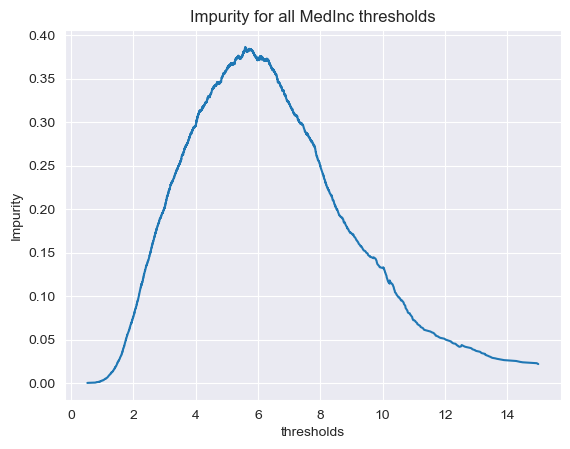

In [288]:
feature = "MedInc"

thres, Q_array, t_best, g_best = find_best_split(X[feature], y, "regression", "real")
print(thres)
print(Q_array)
print(t_best)
print(g_best)

plt.plot(thres, Q_array)
plt.title(f"Impurity for all {feature} thresholds")
plt.xlabel("thresholds")
plt.ylabel("Impurity")
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [73]:
# Переберу все пороги
for feature in X.columns.values:
    _, _, t_best, g_best = find_best_split(X[feature], y, "regression", "real")
    print(f"{feature}: {t_best=} {g_best=}")

MedInc: t_best=5.5892 g_best=0.38642793042157203
HouseAge: t_best=51.5 g_best=0.017133556953581486
AveRooms: t_best=6.510000444464199 g_best=0.1013358914339873
AveBedrms: t_best=1.1201633562897162 g_best=0.017849004948487013
Population: t_best=339.5 g_best=0.002017708385245731
AveOccup: t_best=3.0825298307003988 g_best=0.02842573599407322
Latitude: t_best=37.925 g_best=0.04272743684724602
Longitude: t_best=-121.85499999999999 g_best=0.03709143052207742


Лучшим оказался предикат критерия MedInc. t_best=5.5892

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия. - ВЫПОЛНИЛ**
- **Реализуйте метод оценки важности признаков.**

In [323]:
# Для заполнения пропусков я заполняю всё пропуски нулями
# Цитата из конспектов ПМИ:
# Отметим, что нередко схожее качество показывают и гораздо более простые способы обработки пропусков например,
# можно заменить все пропуски на ноль. Для деревьев также разумно будет заменить пропуски в признаке на числа,
# которые превосходят любое значение данного признака. В этом случае в дереве можно будет выбрать такое
# разбиение по этому признаку, что все объекты с известными значениями пойдут в левое поддерево, а все объекты с
# пропусками в правое.

class DecisionTree:
    def __init__(
            self,
            feature_types: Union[List[str], np.ndarray],
            max_depth: int = None,
            min_samples_split: int = None,
            min_samples_leaf: int = None,
            task: str = "classification"
    ) -> None:
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

    def _fit_node(
            self,
            sub_X: np.ndarray,
            sub_y: np.ndarray,
            node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # лист
        if node["type"] == "terminal":
            return node["class"]

        # предикат
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:

        X[np.isnan(X)] = 0  # Заполню пропуски нулями для их обработки
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X[np.isnan(X)] = 0  # Заполню пропуски нулями для их обработки
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [324]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv")
X = pd.DataFrame(data.drop(columns=["Unnamed: 0", "UNS"]))
y = data["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


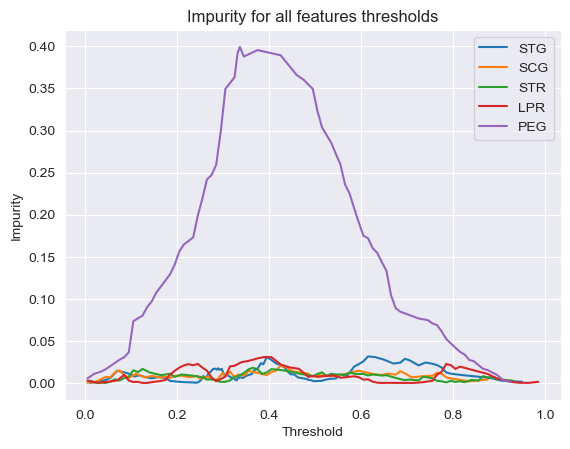

In [325]:
# Вместо обычного критерия Джини дополнительно использовал критерий информативности
# Чтобы лучше увидеть разделимость порогов

features = ["STG", "SCG", "STR", "LPR", "PEG"]
for feature in features:
    thres, Q_array, _, _ = find_best_split(X[feature], y, "classification", "real")
    plt.plot(thres, Q_array, label=feature)
plt.title("Impurity for all features thresholds")
plt.xlabel("Threshold")
plt.ylabel("Impurity")
plt.legend()
plt.show()

И для критерия джини

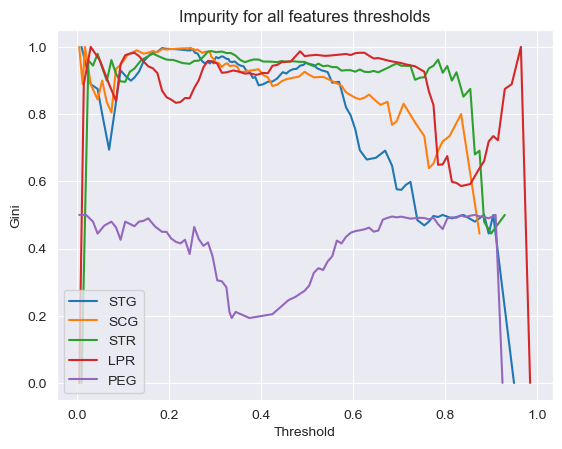

In [306]:
features = ["STG", "SCG", "STR", "LPR", "PEG"]
for feature in features:
    thres, Q_array, _, _ = find_best_split_gini(X[feature], y, "classification", "real")
    plt.plot(thres, Q_array, label=feature)
plt.title("Impurity for all features thresholds")
plt.xlabel("Threshold")
plt.ylabel("Gini")
plt.legend()
plt.show()

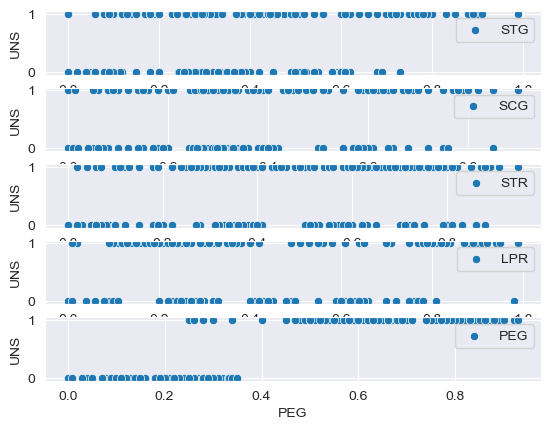

In [61]:
_, ax = plt.subplots(5, 1)

features = ["STG", "SCG", "STR", "LPR", "PEG"]
for feature_ind in range(len(features)):
    sns.scatterplot(x=X[features[feature_ind]], y=y, label=features[feature_ind], ax=ax[feature_ind])

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [29]:
# Производить деление выборки на два поддерева стоит производить по признаку PEG.
# Этот результат согласуется с диаграммой рассеивания
# Хорошая кривая должна иметь высокие значения хаотичности ближе к средним порогам, идеально - в середине
# невозможные признаки скорее напоминают впадину, которая поднимается только у левого или правого края
# В случае с критерием Джини, наоборот, должны быть значения внизу ближе к средним порогам

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [307]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
print(f"Dataset shape: {data.shape}")
data

Dataset shape: (8123, 23)


,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [308]:
data = data.apply(LabelEncoder().fit_transform)
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [309]:
target = "p"

X = data.drop(columns=[target])
y = data[target]
display(X)
display(y)

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
1,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
2,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
3,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
4,5,3,9,1,0,1,0,0,5,0,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8119,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8120,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8121,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


0       0
1       0
2       1
3       0
4       0
       ..
8118    0
8119    0
8120    0
8121    1
8122    0
Name: p, Length: 8123, dtype: int32

In [310]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Проверю сначала на моделе из sklearn

In [311]:
dt = DecisionTreeClassifier()
y = dt.fit(X_train, y_train)

In [312]:
print(accuracy_score(y_train, dt.predict(X_train)))
print(accuracy_score(y_test, dt.predict(X_test)))  # неплохой результат

1.0
1.0


А теперь на своей

In [313]:
X.isnull().count()  # Заметим, что в данных есть пропуски, которые я обрабатываю в коде дерева

x      8123
s      8123
n      8123
t      8123
p.1    8123
f      8123
c      8123
n.1    8123
k      8123
e      8123
e.1    8123
s.1    8123
s.2    8123
w      8123
w.1    8123
p.2    8123
w.2    8123
o      8123
p.3    8123
k.1    8123
s.3    8123
u      8123
dtype: int64

In [314]:
dt = DecisionTree(feature_types=['categorical'] * len(X.columns), task="classification")
dt.fit(X_train.to_numpy(), y_train.to_numpy())  # только спустя двое суток я догадался преобразовать в numpy...

In [315]:
print(accuracy_score(y_train, dt.predict(X_train.to_numpy())))
print(accuracy_score(y_test, dt.predict(X_test.to_numpy())))
# Результы такие хорошие, потому что я реализовал заполнение пропусков

1.0
1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [83]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [84]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [85]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

Посмотрим на распределение целевой переменной

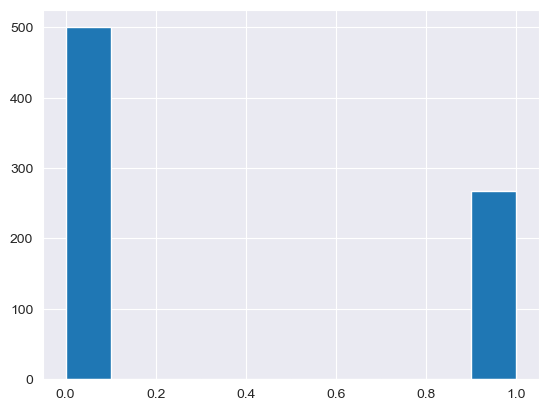

In [86]:
data['Outcome'].hist()
plt.show()
# 0 в два раза больше, возможно стоит использовать SMOTE

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train,
                                                              random_state=5)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [88]:
params = {
    # Данных и деревьев мало, так что можно
    "max_depth": range(1, 100),
    "min_samples_leaf": range(1, 100)
}
best_f1_score = 0
best_params = {
    "max_depth": None,
    "min_samples_leaf": None
}
for md in params["max_depth"]:
    for msl in params["min_samples_leaf"]:
        dt_classifier = DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl)
        dt_classifier.fit(X_train_train, y_train_train)
        current_f1_score = f1_score(y_val, dt_classifier.predict(X_val))
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_params["max_depth"] = md
            best_params["min_samples_leaf"] = msl

In [89]:
best_f1_score

0.7068965517241379

In [90]:
best_params["max_depth"]

4

In [91]:
best_params["min_samples_leaf"]

28

In [92]:
dt_classifier = DecisionTreeClassifier(max_depth=best_params["max_depth"],
                                       min_samples_leaf=best_params["min_samples_leaf"])
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=28)

In [93]:
prediction = dt_classifier.predict(X_test)
print(f"{accuracy_score(y_test, prediction)}")
print(f"{precision_score(y_test, prediction)}")
print(f"{recall_score(y_test, prediction)}")
print(f"{roc_auc_score(y_test, prediction)}")
print(f"{f1_score(y_test, prediction)}")
# Плохие результаты. Переобучилась

0.7359307359307359
0.6470588235294118
0.5432098765432098
0.691604938271605
0.5906040268456376


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [94]:
bagging_classifier = BaggingClassifier(n_estimators=50)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(n_estimators=50)

In [95]:
prediction = bagging_classifier.predict(X_test)
print(f"{accuracy_score(y_test, prediction)}")
print(f"{precision_score(y_test, prediction)}")
print(f"{recall_score(y_test, prediction)}")
print(f"{roc_auc_score(y_test, prediction)}")
print(f"{f1_score(y_test, prediction)}")
# Уже лучше

0.7489177489177489
0.6716417910447762
0.5555555555555556
0.7044444444444444
0.6081081081081081


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [96]:
# Надеюсь, что можно использовать GridSearchCV
rf_сlassifier = RandomForestClassifier(n_estimators=50)

params_rf = {
    'max_depth': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60, 80, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60, 80, 100],
}

# Инициализация GridSearchCV для случайного лесса
rf_model = GridSearchCV(rf_сlassifier, param_grid=params_rf, cv=5, scoring='f1', refit=True)

# подбор гиперпараметров
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60,
                                       80, 100],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40,
                                              60, 80, 100]},
             scoring='f1')

In [97]:
print("Best parameters for RandomForest:", rf_model.best_params_)
print("Best f1 score for RandomForest:", rf_model.best_score_)

Best parameters for RandomForest: {'max_depth': 25, 'min_samples_leaf': 1}
Best f1 score for RandomForest: 0.6618288452840692


Рассмотрим гиперпараметры около лучших

In [98]:
# Надеюсь, что можно использовать GridSearchCV
rf_сlassifier = RandomForestClassifier(n_estimators=50)

params_rf = {
    'max_depth': range(15, 25),
    'min_samples_leaf': range(1, 6),
}

# Инициализация GridSearchCV для случайного лесса
rf_model = GridSearchCV(rf_сlassifier, param_grid=params_rf, cv=5, scoring='f1', refit=True)

# подбор гиперпараметров
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': range(15, 25),
                         'min_samples_leaf': range(1, 6)},
             scoring='f1')

In [99]:
print("Best parameters for RandomForest:", rf_model.best_params_)
print("Best f1 score for RandomForest:", rf_model.best_score_)

Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 2}
Best f1 score for RandomForest: 0.6643834625683129


In [100]:
rf_сlassifier = RandomForestClassifier(n_estimators=50, max_depth=rf_model.best_params_['max_depth'],
                                       min_samples_leaf=rf_model.best_params_['min_samples_leaf'])
rf_сlassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=50)

In [101]:
prediction = rf_сlassifier.predict(X_test)
print("50 с гиперпараметрами")
print(f"{accuracy_score(y_test, prediction)}")
print(f"{precision_score(y_test, prediction)}")
print(f"{recall_score(y_test, prediction)}")
print(f"{roc_auc_score(y_test, prediction)}")
print(f"{f1_score(y_test, prediction)}")


50 с гиперпараметрами
0.7705627705627706
0.7058823529411765
0.5925925925925926
0.7296296296296296
0.6442953020134228


Выглядит так, что модель сильно недообучилась
Попробую на всякий случай обучить с 500 деревьев с подбором новых параметров

In [102]:
# Надеюсь, что можно использовать GridSearchCV
rf_сlassifier = RandomForestClassifier(n_estimators=500)

params_rf = {
    'max_depth': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60, 80, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60, 80, 100],
}

# Инициализация GridSearchCV для случайного лесса
rf_model = GridSearchCV(rf_сlassifier, param_grid=params_rf, cv=5, scoring='f1', refit=True)

# подбор гиперпараметров
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=500),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40, 60,
                                       80, 100],
                         'min_samples_leaf': [1, 3, 5, 7, 9, 12, 15, 20, 25, 40,
                                              60, 80, 100]},
             scoring='f1')

In [103]:
print("Best parameters for RandomForest:", rf_model.best_params_)
print("Best f1 score for RandomForest:", rf_model.best_score_)

Best parameters for RandomForest: {'max_depth': 25, 'min_samples_leaf': 3}
Best f1 score for RandomForest: 0.650468634365069


In [104]:
rf_сlassifier = RandomForestClassifier(n_estimators=500, max_depth=rf_model.best_params_['max_depth'],
                                       min_samples_leaf=rf_model.best_params_['min_samples_leaf'])
rf_сlassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_leaf=3, n_estimators=500)

In [105]:
prediction = rf_сlassifier.predict(X_test)
print(f"{accuracy_score(y_test, prediction)}")
print(f"{precision_score(y_test, prediction)}")
print(f"{recall_score(y_test, prediction)}")
print(f"{roc_auc_score(y_test, prediction)}")
print(f"{f1_score(y_test, prediction)}")


0.7619047619047619
0.6857142857142857
0.5925925925925926
0.7229629629629629
0.6357615894039735


Качество, на удивление, чуть хуже, чем у бэггинга. Скорее всего дело в random_state

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

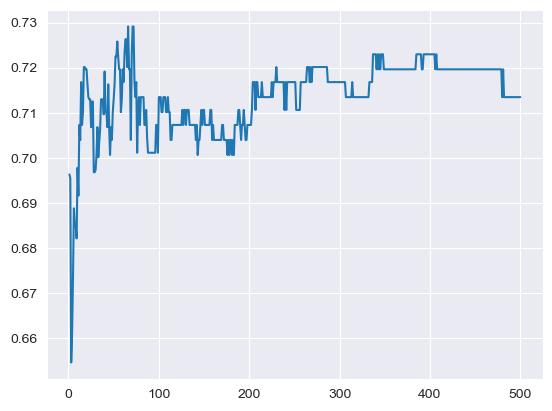

In [106]:
n = 500
aucs = []
for i in range(1, n + 1):
    rf_cur = RandomForestClassifier(n_estimators=i, max_depth=rf_model.best_params_['max_depth'],
                                    min_samples_leaf=rf_model.best_params_['min_samples_leaf'], random_state=0)
    rf_cur.fit(X_train, y_train)
    aucs.append(roc_auc_score(y_test, rf_cur.predict(X_test)))
plt.plot(range(1, n + 1), aucs)

Можно сделать выводы, что чем больше деревьев, тем лучше. Но при этом при большом количестве деревьев, очевидно, модель будет обучаться дольше. В случайном лесе с каждой итерацией variance становится меньше или практически не меняется.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [107]:
rf_сlassifier.feature_importances_

array([0.07485002, 0.31300006, 0.07234602, 0.05774024, 0.06303738,
       0.15653438, 0.12754637, 0.13494554])

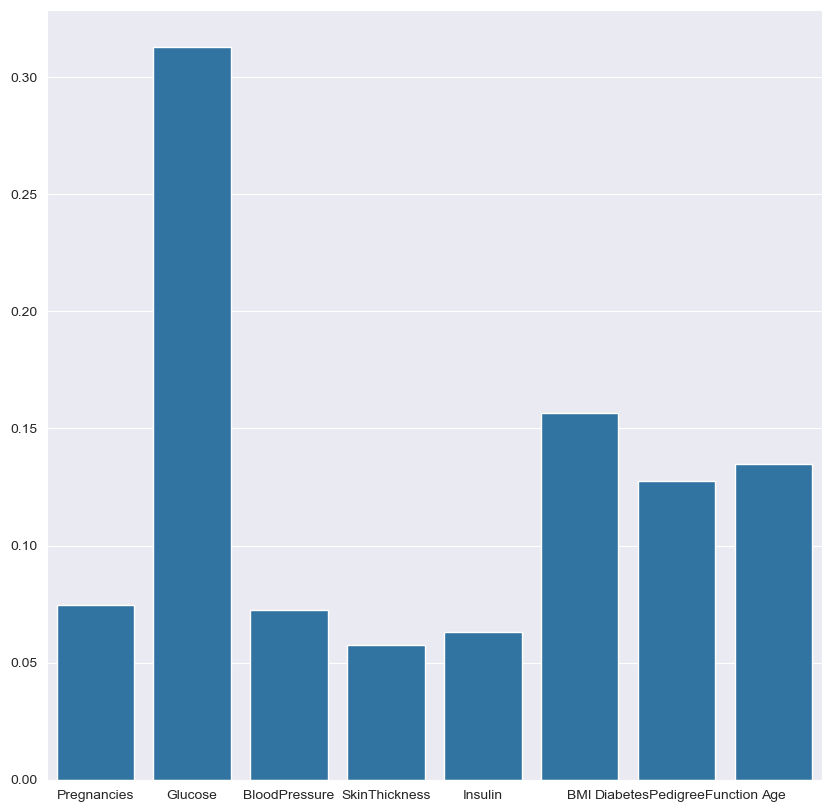

In [108]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.barplot(x=X.columns.values, y=rf_сlassifier.feature_importances_)
plt.show()

Самым важным признаком окажется количество глюкозы в крови